In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from scipy.io import loadmat
from time import time
#import umap

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, mutual_info_score, rand_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the data
data_array = loadmat('/content/drive/MyDrive/Indian_pines_corrected.mat')['indian_pines_corrected'] # Hyperspectral data
gt = loadmat('/content/drive/MyDrive/Indian_pines_gt.mat')['indian_pines_gt'] # Ground truth data

In [ ]:
# visualisation
# read and enhance
def plot_array_stretched(array, label, n):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    cb = plt.imshow(array, cmap='Greys_r', vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    plt.colorbar(cb, shrink=1, label=label)
    plt.show()

@interact(band=range(1, data_array.shape[2]+1))
def show_dist(band):
    plot_array_stretched(data_array[:, :, band-1], f'Band {band}', 2)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

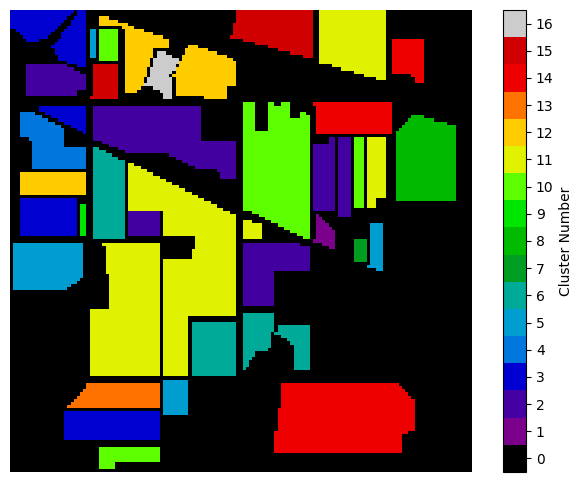

In [ ]:
def plot_data(data, n_clusters):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    cmap = cm.get_cmap('nipy_spectral', n_clusters)
    plt.imshow(data, cmap=cmap)
    cbar = plt.colorbar(label='Cluster Number')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    
    plt.show()

plot_data(gt, 17)

In [ ]:
# Reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

In [ ]:
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  return df 

df = extract_pixels(data_array, gt)
print("Length of df: ",len(df))
df.head()

Length of df:  21025


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


# Principal Component Analysis (PCA)

In [ ]:
# PCA
pca = PCA(random_state=1)
components = pca.fit_transform(data_reshaped)
eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.9:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected principal components: {i}')

Number of spectral bands: 200
Number of selected principal components: 2


<Axes: xlabel='class', ylabel='Feature-1'>

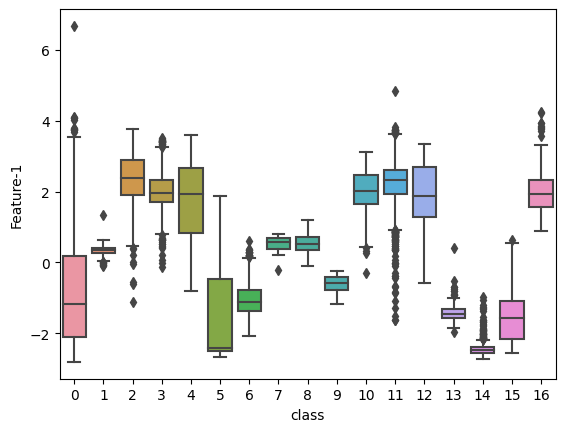

In [ ]:
import seaborn as sns
df = pd.concat([pd.DataFrame(data = selected_components), pd.DataFrame(data = gt.ravel())], axis = 1)
df.columns = [f'Feature-{i}' for i in range(1,3)]+['class']
#sns.boxplot(x=df.iloc[:,2],y=df.iloc[:,0])
sns.boxplot(x = df['class'],
            y = df['Feature-1'],
)

<Axes: xlabel='class', ylabel='Feature-2'>

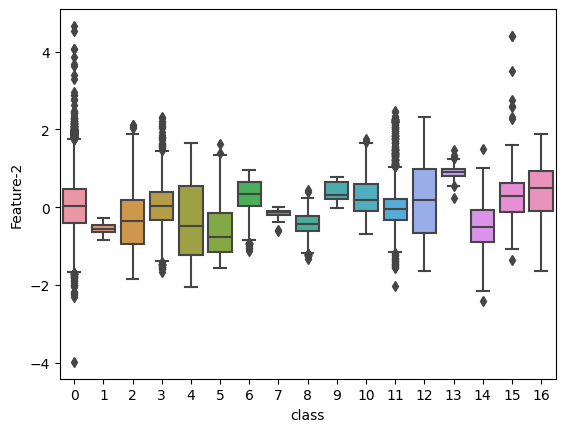

In [ ]:
sns.boxplot(x = df['class'],
            y = df['Feature-2'],
)

# K-means

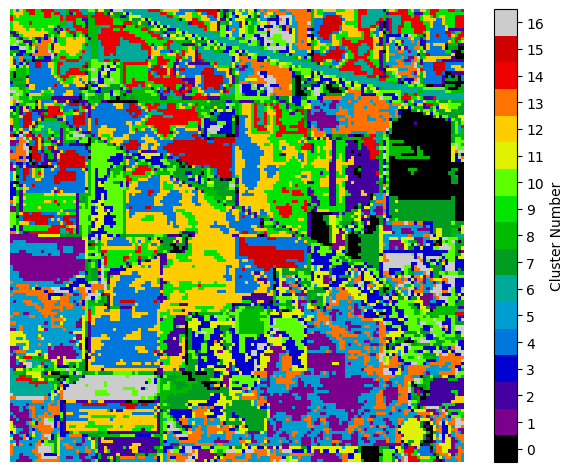

In [ ]:
# k-means clustering using the components generated in the previous cell
# init, n_init, max_iter, algorithm
k_means = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = k_means.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

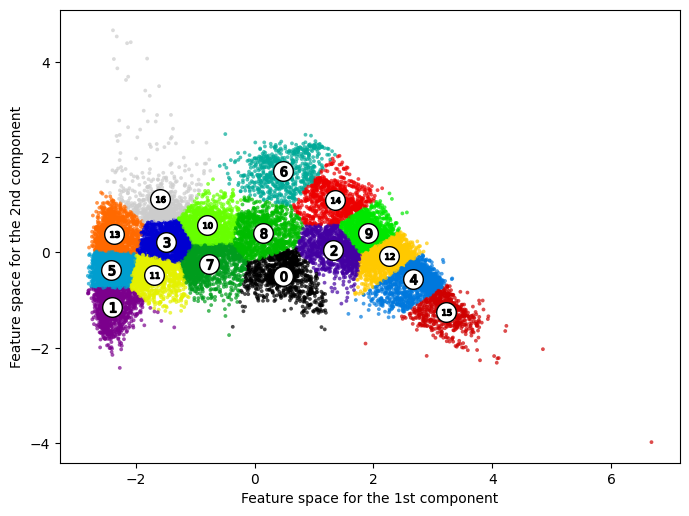

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components[:, 0],
    selected_components[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = k_means.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_pca.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.369762,41238.875944,0.815947,0.355945,0.245689,0.290714,0.695189,0.056849,0.650227,0.288964
16.0,0.360363,40801.475882,0.828143,0.358753,0.241576,0.288729,0.698069,0.059292,0.655356,0.286875
17.0,0.362289,40722.556225,0.809769,0.363130,0.238912,0.288206,0.697892,0.053435,0.663351,0.286252
18.0,0.365237,40445.652379,0.788400,0.366793,0.236163,0.287328,0.700278,0.055829,0.670044,0.285274
19.0,0.368905,40231.553336,0.791605,0.366809,0.236580,0.287641,0.697040,0.047972,0.670072,0.285474


# MiniBatch K-means

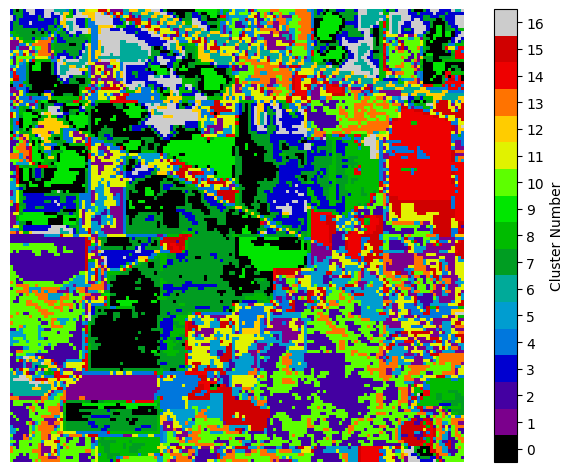

In [ ]:
# minibatch k-means clustering using the principal components
# init, batch_size, max_iter, max_no_improvement, reassignment_ratio, n_init
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = minibatch_kmeans.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

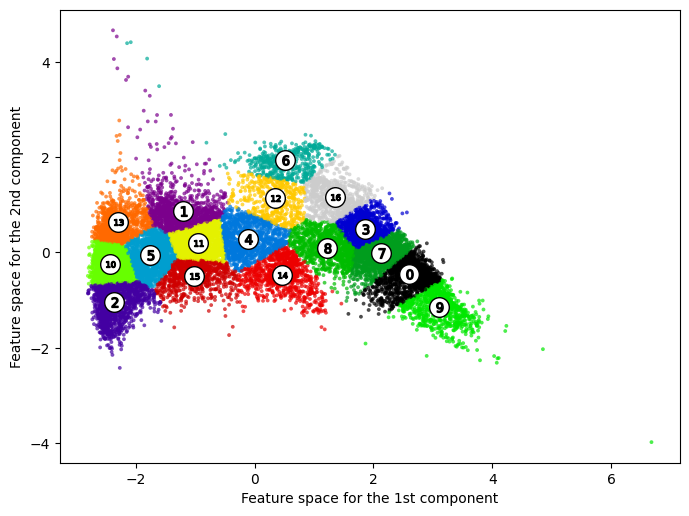

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components[:, 0],
    selected_components[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = minibatch_kmeans.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_minibatch_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_minibatch_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_minibatch_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.351782,37254.555316,0.875928,0.357592,0.247154,0.292289,0.696984,0.062594,0.653235,0.290542
16.0,0.355579,38823.537219,0.873577,0.355091,0.240223,0.286575,0.695108,0.052297,0.648668,0.284710
17.0,0.348977,38189.416212,0.849691,0.357310,0.237208,0.285128,0.697060,0.054061,0.652721,0.283156
18.0,0.351643,37845.066395,0.835224,0.363177,0.235259,0.285547,0.700170,0.057554,0.663439,0.283482
19.0,0.345755,37951.822575,0.836350,0.363575,0.230536,0.282159,0.700314,0.053067,0.664164,0.279989


# Bisecting K-means

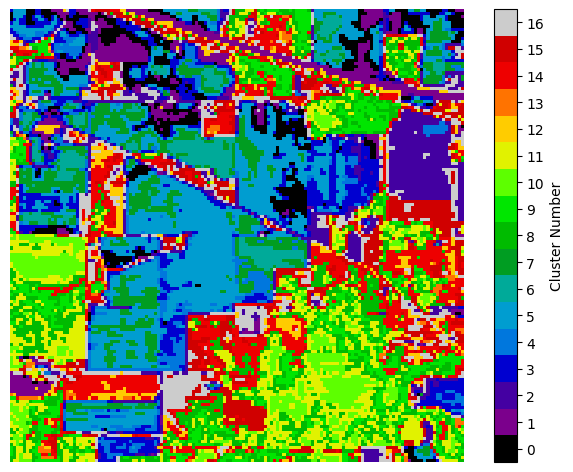

In [ ]:
  # bisecting k-means clustering using the principal components
  # init, n_init, max_iter, bisecting_strategy, algorithm
  bisecting_kmeans = cluster.BisectingKMeans(n_clusters=17, random_state=1) # create an object of the classifier
  labels = bisecting_kmeans.fit_predict(selected_components) # train
  labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
  plot_data(labels_2d, 17)

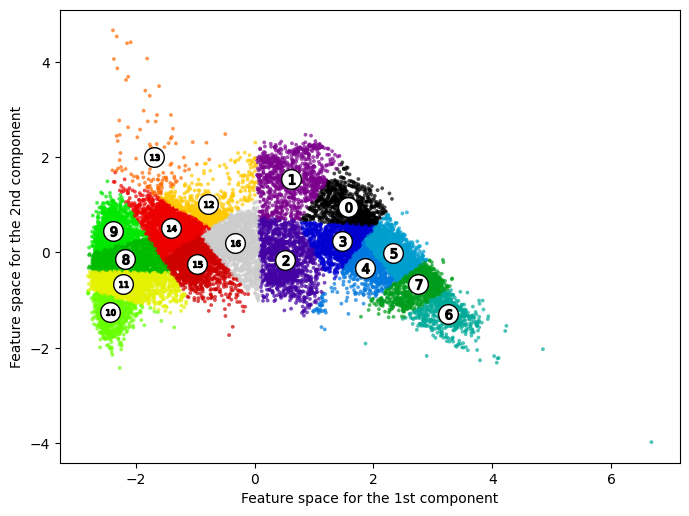

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components[:, 0],
    selected_components[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = bisecting_kmeans.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_bisecting_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.BisectingKMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_bisecting_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_bisecting_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.310011,33277.349298,1.032625,0.336536,0.232914,0.275297,0.695648,0.059424,0.614771,0.273506
16.0,0.305952,33565.996736,1.019244,0.339968,0.230342,0.274619,0.697845,0.061858,0.621041,0.272720
17.0,0.305894,33194.150557,0.984151,0.340825,0.229661,0.274412,0.697819,0.061410,0.622607,0.272398
18.0,0.305303,33218.664207,0.974755,0.345072,0.228710,0.275092,0.698477,0.060872,0.630365,0.272973
19.0,0.304208,33285.008714,0.958057,0.346060,0.222102,0.270559,0.702220,0.062251,0.632170,0.268343


# BIRCH

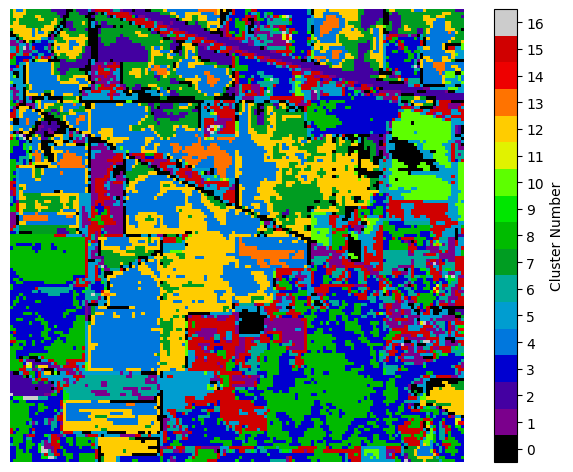

In [ ]:
# birch clustering using the components generated in the previous cell
# threshold, branching_factor
birch = cluster.Birch(n_clusters=17) # create an object of the classifier
labels = birch.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_birch = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.Birch(n_clusters=n_clusters)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_birch.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_birch.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.303500,27351.313912,0.849794,0.331378,0.258209,0.290253,0.694019,0.092022,0.605349,0.288468
16.0,0.334704,30694.885075,0.839591,0.336359,0.249982,0.286808,0.689928,0.064276,0.614448,0.284929
17.0,0.331855,28916.032401,0.830553,0.336409,0.249678,0.286626,0.689920,0.064239,0.614539,0.284633
18.0,0.329495,28576.327249,0.819956,0.340166,0.248501,0.287196,0.690021,0.062586,0.621402,0.285091
19.0,0.324633,27646.860053,0.845858,0.343352,0.248272,0.288172,0.690198,0.062284,0.627222,0.285954


# Spectral Clustering

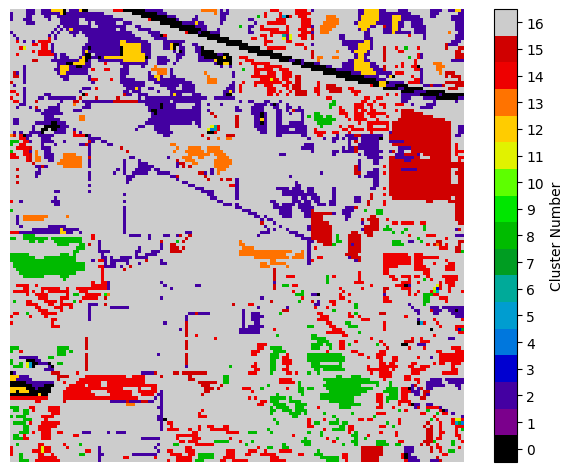

In [ ]:
# spectral clustering using the components generated in the previous cell
# eigen_solver, affinity, degree, n_init
spectral = cluster.SpectralClustering(n_clusters=17, random_state=1, n_jobs=-1) # create an object of the classifier
labels = spectral.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_spectral = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.SpectralClustering(n_clusters=17, random_state=1, n_jobs=-1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_spectral.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_spectral.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,-0.229043,476.970297,1.369439,0.120962,0.197076,0.149911,0.49671,0.002659,0.220969,0.147549
16.0,-0.229043,476.970297,1.369439,0.120962,0.197076,0.149911,0.49671,0.002659,0.220969,0.147549
17.0,-0.229043,476.970297,1.369439,0.120962,0.197076,0.149911,0.49671,0.002659,0.220969,0.147549
18.0,-0.229043,476.970297,1.369439,0.120962,0.197076,0.149911,0.49671,0.002659,0.220969,0.147549
19.0,-0.229043,476.970297,1.369439,0.120962,0.197076,0.149911,0.49671,0.002659,0.220969,0.147549


# Agglomerative Clustering

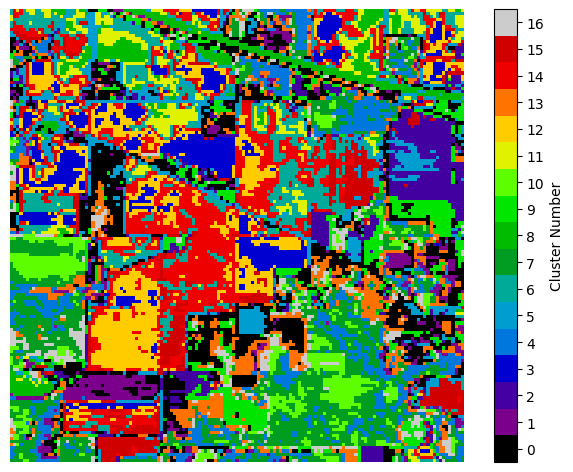

In [ ]:
# agglomerative clustering using the components generated in the previous cell
# affinity, linkage
agglomerative = cluster.AgglomerativeClustering(n_clusters=17) # create an object of the classifier
labels = agglomerative.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_agglomerative = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.AgglomerativeClustering(n_clusters=17)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_agglomerative.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_agglomerative.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.315907,34671.999646,0.92239,0.351216,0.232554,0.279825,0.698475,0.058212,0.641588,0.27784
16.0,0.315907,34671.999646,0.92239,0.351216,0.232554,0.279825,0.698475,0.058212,0.641588,0.27784
17.0,0.315907,34671.999646,0.92239,0.351216,0.232554,0.279825,0.698475,0.058212,0.641588,0.27784
18.0,0.315907,34671.999646,0.92239,0.351216,0.232554,0.279825,0.698475,0.058212,0.641588,0.27784
19.0,0.315907,34671.999646,0.92239,0.351216,0.232554,0.279825,0.698475,0.058212,0.641588,0.27784
